In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random

import importlib
import transformers
from transformers import models

importlib.reload(models)

<module 'transformers.models' from '/home/radarlab18/anaconda3/envs/Segformer/lib/python3.8/site-packages/transformers/models/__init__.py'>

In [4]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval

        self.num_classes = 21
        # self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            ignore_mismatched_sizes=True,
            num_labels=self.num_classes
        )
    
        
        
    def forward(self, images, ):
        outputs = self.model(pixel_values=images)
        
        return(outputs)
    
    
    def load_from_checkpoint(checkpoint_path, id2label=None, metrics_interval=100):
        # 创建实例
        model = SegformerFinetuner(id2label=id2label, metrics_interval=metrics_interval)
        
        # 加载检查点
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        print(checkpoint.keys())
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        
        return model

In [35]:
import cv2
import torch

device = torch.device("cpu")

featureExtractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")


image = Image.open("/home/radarlab18/disk_sdb1/Segformer-MC/VICK_SYU_MODIFICATION/image_10216.jpg")
# image2=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
pixel_values = featureExtractor(image.convert("RGB"), return_tensors="pt").pixel_values.to(device)

print(pixel_values.shape)

checkPointPath = '/home/radarlab18/disk_sdb1/Segformer-MC/checkpoints/epoch=168-step=4056.ckpt'
model = SegformerFinetuner.load_from_checkpoint(checkPointPath)
model.to(device)

with torch.no_grad():
    outputs = model(pixel_values)
    logits = outputs[0]
    print(outputs)





torch.Size([1, 3, 512, 512])


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([21]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([21, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
(tensor([[[[ 0.9969,  1.0573,  0.9424,  ...,  0.6339,  0.6463,  0.6854],
          [ 0.8207,  0.6498,  0.6058,  ...,  0.3669,  0.4000,  0.3540],
          [ 0.4810,  0.4297,  0.3321,  ...,  0.0963,  0.1252,  0.1784],
          ...,
          [-0.5285, -0.6644, -0.7083,  ..., -0.5231, -0.4629, -0.3969],
          [-0.4700, -0.5650, -0.6201,  ..., -0.4141, -0.3331, -0.2849],
          [-0.4329, -0.5082, -0.5634,  ..., -0.3683, -0.2969, -0.2380]],

         [[-2.2667, -2.4243, -2.6966,  ..., -2.3913, -2.3287, -2.2469],
          [-2.6268, -2.8524, -2.9479,  ..., -2.6018, -2.5722, -2.4700],
          [-2.6148, -2.7241, -2.7554,  ..., -2.3402, -2.3526, -2.3824],
          ...,
          [-1.6617, -2.1444, -2.0293,  ..., -1.9624, -1.8718, -1.7879],
          [-1.7286, -2.3042, -2.0766,  ..., -1.8785, -1.7816, -1.8275],
          [-1.3678, -2.1843, -2.0307,

In [36]:
import torch

# Define the function to enable dropout during inference
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Define the function to perform multiple stochastic forward passes
def mc_forward_passes(model, pixel_values, n_passes=30):
    model.eval()
    enable_dropout(model)
    
    predictions = []
    with torch.no_grad():
        for _ in range(n_passes):
            outputs = model(pixel_values)
            logits = outputs[0]
            predictions.append(logits.unsqueeze(0))
    
    predictions = torch.cat(predictions, dim=0)
    return predictions

# Define the function to calculate uncertainty metrics
def calculate_uncertainty(predictions):
    mean_prediction = predictions.mean(dim=0)
    variance = predictions.var(dim=0)
    probs = torch.softmax(predictions, dim=2)
    mean_probs = probs.mean(dim=0)
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
    
    return mean_prediction, variance, entropy

# Load your model and input data
# model = ... (your Segformer model)
# pixel_values = ... (your input tensor)

# Perform MC dropout inference
predictions = mc_forward_passes(model, pixel_values, n_passes=30)

# Calculate uncertainty
mean_prediction, variance, entropy = calculate_uncertainty(predictions)

# Now you can use mean_prediction, variance, and entropy for further analysis


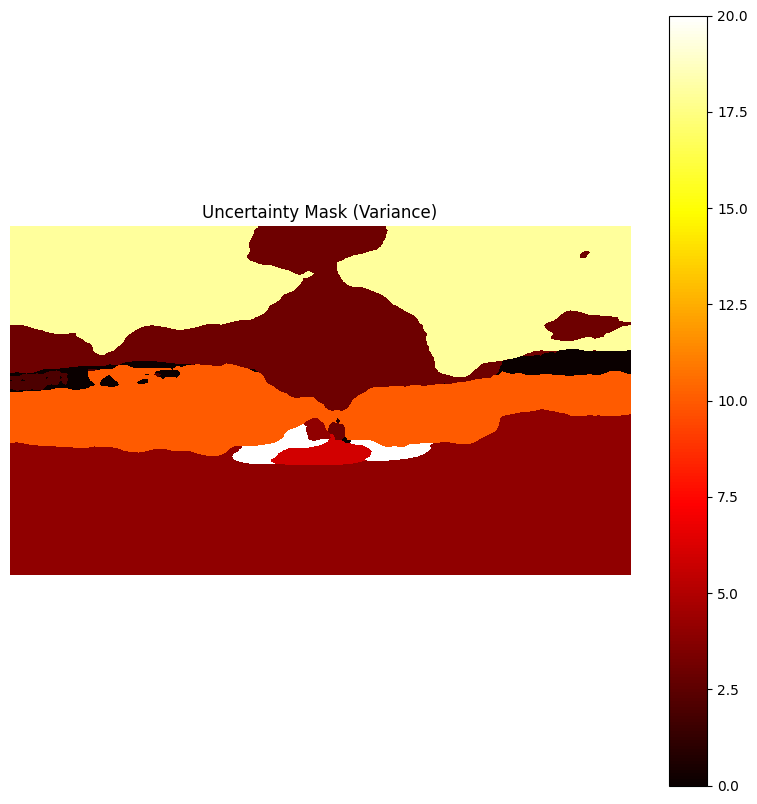

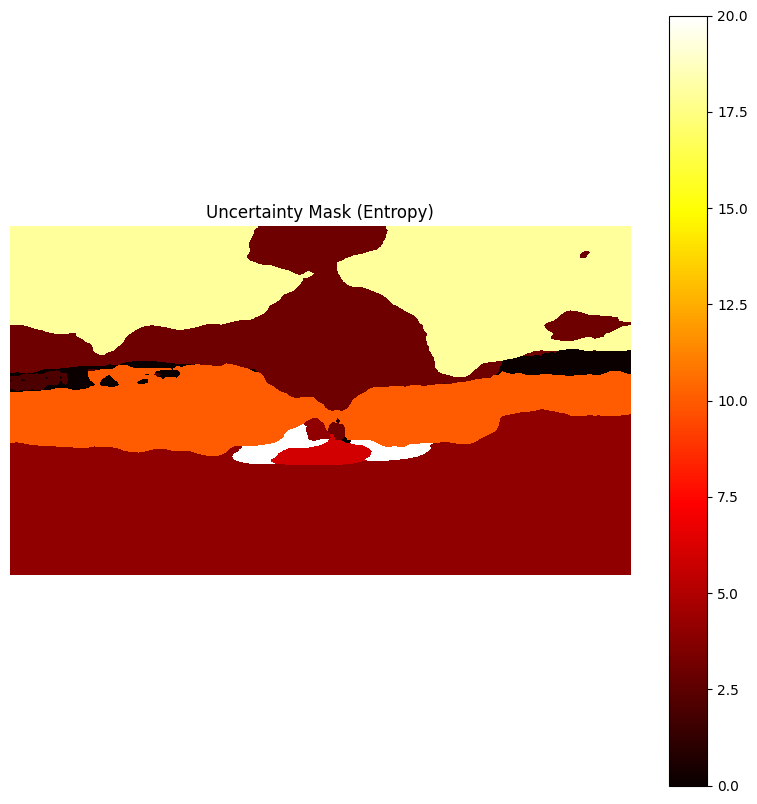

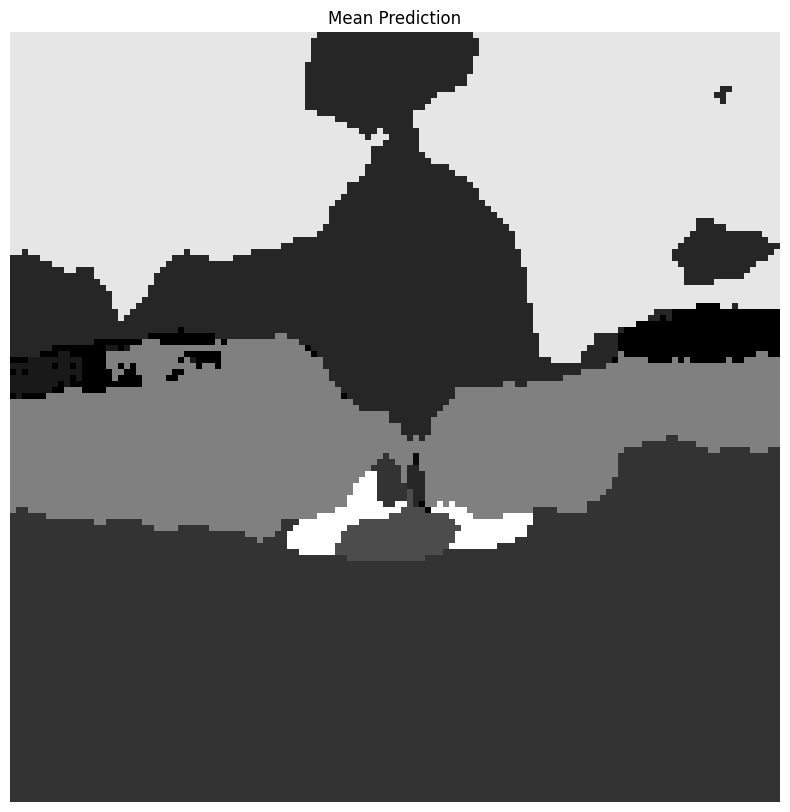

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assume mean_prediction, variance, and entropy are obtained from the previous steps

def normalize(tensor):
    """ Normalize tensor to range [0, 1] """
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    return normalized_tensor

def visualize_uncertainty(uncertainty_mask, title="Uncertainty Mask"):
    """ Visualize the uncertainty mask """
    # Convert tensor to numpy array
    uncertainty_mask = uncertainty_mask.cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    uncertainty_mask_plot = featureExtractor.post_process_semantic_segmentation(outputs, target_sizes=[[720,1280]])[0]
    uncertainty_mask_plot = uncertainty_mask_plot.cpu().numpy()
    plt.imshow(uncertainty_mask_plot, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()
    

# Normalize the uncertainty values
normalized_variance = normalize(variance)
normalized_entropy = normalize(entropy)

# Visualize the uncertainty masks
visualize_uncertainty(normalized_variance, title="Uncertainty Mask (Variance)")
visualize_uncertainty(normalized_entropy, title="Uncertainty Mask (Entropy)")

# Optionally, visualize the mean prediction as well
mean_prediction_np = mean_prediction.argmax(dim=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(mean_prediction_np[0], cmap='gray', interpolation='nearest')
plt.title("Mean Prediction")
plt.axis('off')
plt.show()



In [38]:

def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]


image_array = np.array(image)
predicted_segmentation_map = featureExtractor.post_process_semantic_segmentation(outputs, target_sizes=[[image_array.shape[0],image_array.shape[1]]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)
print(predicted_segmentation_map.shape)

print(np.unique(predicted_segmentation_map))


[[18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 ...
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]]
(512, 640)
[ 0  1  2  3  4  6 10 18 20]


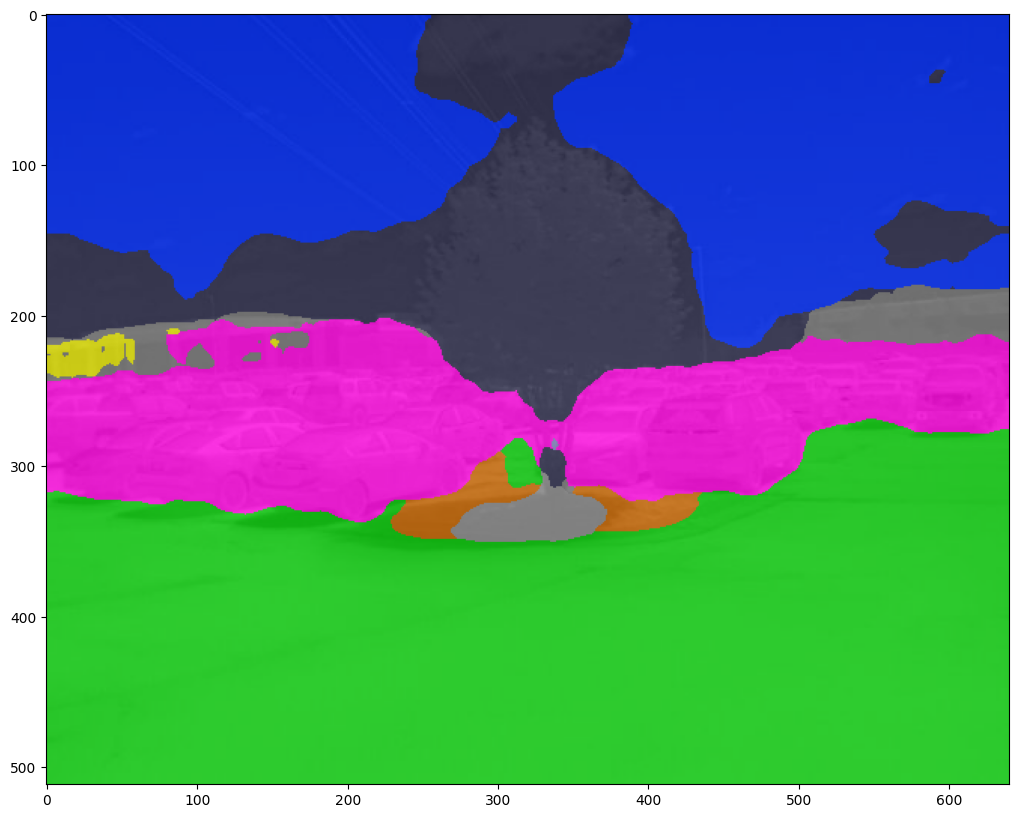

In [39]:
import matplotlib.pyplot as plt
import numpy as np
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.2 + color_seg * 0.8
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()
